<a href="https://colab.research.google.com/github/fivearm/Phase_4_Project/blob/ninas_branch/check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%matplotlib inline

Mounted at /content/gdrive


In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/zillow_data.csv')
lumber = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/plywood_prices.csv')
concrete = pd.read_csv('/content/gdrive/MyDrive/Phase_4_Project/data/concrete_prices.csv')

lumber = lumber.rename({'WPU083': 'plywood prices', 'DATE': 'time'}, axis=1).set_index('time')
concrete = concrete.rename({'PCU32733273': 'concrete prices', 'DATE' : 'time'}, axis = 1).set_index('time')

In [3]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [4]:
def melt_data(df, compress = False):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if compress == True:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted.groupby('time').aggregate({'value':'mean'})
    else:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted

In [7]:
def seasonal_plot(df, window = None, X = None, y = None):
    '''
    Plotting the seasonal decompose
    
    Parameters
    -----------
    df : The dataframe you wish to decompose
    window : The rolling window
    X : The length of the plot
    y : The Height of the plot
    
    Return 
    -----------
    A seasonal decompose of the dataframe. 
    '''
    result = seasonal_decompose(df.rolling(window).mean().dropna())
    plt.rcParams['figure.figsize'] = (X,y)
    result.plot();

In [8]:
def adfuller_test(df, name = None):
    '''
    Take a dataframe or series and returns the adfuller test for it.
    
    Parameters
    -----------
    df : dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = adfuller(df)
    print(f'Adfuller test for {name}')
    print('-'*20)
    print('Test Stastic = {:.3f}'.format(df_test[0]))
    print('P-value = {:.3f}'.format(df_test[1]))
    print('Critical values :')
    for k, v in df_test[4].items():
        print(f"{k}: {v} - The data is {'not' if v < df_test[0] else ''} stationary with {100 - int(k[:-1])}% confidence")

In [9]:
def kpss_test(df, name = None):
    '''
    Will return the kpss test
    
    Parmeters
    ----------
    df = dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = kpss(np.log(df), nlags='auto')
    print(f'Is {name} data stationary?')
    print(f'Test stastic = {df_test[0]: .3f}')
    print(f'P-value = {df_test[1]: .3f}')
    print('Critical Values: ')
    for k, v in df_test[3].items():
        print(f'{k}: {v}')

#### HOLD

In [10]:

melt_df= melt_data(df, compress=False).set_index('time')
melt_df = melt_df[melt_df.index >= '2003-12-01']

In [62]:
con_lum = pd.concat([concrete, lumber], axis=1)
con_lum.index = pd.to_datetime(con_lum.index)
final_df = pd.concat([melt_df, con_lum], axis=1)
print(final_df.loc[(final_df['RegionName'] == 60074)])
final_df.head()

            RegionName  RegionID  ...  concrete prices plywood prices
time                              ...                                
2003-12-01       60074     84330  ...            100.0          192.1
2004-01-01       60074     84330  ...            100.9          174.4
2004-02-01       60074     84330  ...            101.7          202.5
2004-03-01       60074     84330  ...            101.7          218.5
2004-04-01       60074     84330  ...            102.4          222.6
...                ...       ...  ...              ...            ...
2017-12-01       60074     84330  ...            164.3          218.1
2018-01-01       60074     84330  ...            165.8          219.8
2018-02-01       60074     84330  ...            166.1          227.9
2018-03-01       60074     84330  ...            168.9          236.5
2018-04-01       60074     84330  ...            169.0          236.6

[173 rows x 10 columns]


,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,concrete prices,plywood prices
time,,,,,,,,,,
2003-12-01,60657,84654,1,Chicago,IL,Chicago,Cook,752300.0,100.0,192.1
2003-12-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,187100.0,100.0,192.1
2003-12-01,77494,91982,3,Katy,TX,Houston,Harris,229600.0,100.0,192.1
2003-12-01,60614,84616,4,Chicago,IL,Chicago,Cook,1012600.0,100.0,192.1
2003-12-01,79936,93144,5,El Paso,TX,El Paso,El Paso,83400.0,100.0,192.1


## Stationarize and Outlier Handling


In [35]:
def is_stationary(df):
  df_test = adfuller(df)
  critical_95 = df_test[4]['5%']
  return critical_95 > df_test[0] 

def make_stationary(df):
  log_transf = np.log2(df)
  
  diff = log_transf.diff().dropna()
  while is_stationary(diff) == False:
    diff = diff.diff().dropna()
  return diff

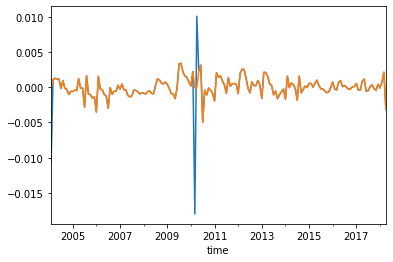

In [55]:
def replace_with_median(col, lower_threshold, median):
    col[col > -lower_threshold] =  median
    col[col < lower_threshold] = median
    return col

def get_replacement_vals(col):
      std = col.std(ddof=0)
      mean = col.mean()
      median = col.median()
      lower_thresh = (-3 * std)+ mean
      return median, lower_thresh

def replace_outliers(train, test=pd.DataFrame()):
  train_copy = train.copy()
  median, lower_thresh = get_replacement_vals(train_copy)
  stand_train = replace_with_median(train_copy, lower_thresh, median)

  if not test.empty:
    test_copy = test.copy()
    stand_test = replace_with_median(test_copy, lower_thresh, median)
    return stand_train, stand_test
  
  return stand_train

by_month = final_df['value'].resample('M').mean()
fig, ax = plt.subplots()
stationary_price = make_stationary(by_month)
stationary_price.plot(ax=ax)

stationary_price_no_outliers = replace_outliers(stationary_price)
stationary_price_no_outliers.plot(ax=ax);


## Cross Validation

In [ ]:
def rmse(y_true, y_pred):
    sum_squared_diff = sum([(y2 - y1)**2 for y2,y1 in zip(y_true, y_pred)])
    rmse = (sum_squared_diff * (1/len(y_true))) ** 0.5
    return rmse

def cross_validate(model, df, split_freq='M', model_kwargs={}):
    '''
    Resamples dataframe using aggregate mean
    Preforms cross validation of the input model. 
    ---------------------------------------------------------------------
    model: uninitalized model- no parantheses 
    split_freq: the frequency to index the data by
    model_kwargs: keyword arguments to pass into the model before fitting
    ---------------------------------------------------------------------
    Returns: An array of RMSE
    '''
    
    df = df.resample(split_freq).mean()
    all_rmse = []
    # Create and loop through 4 different train and validation sets
    split = TimeSeriesSplit(n_splits=4)
    for train_ind, val_ind in split.split(df):
        # Initialize, fit, and generate predictions the model on subset of df
        model_fit = model(df.iloc[train_ind], **model_kwargs).fit()
        preds = model_fit.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
        
        # Grab Y actual from df
        true = df.iloc[val_ind]
        
        # Calculate and store RMSE
        all_rmse.append(rmse(true, preds))
    return all_rmse 

cross_validate(ARIMA, Miami_df['value'], 'M', model_kwargs={'order':(1,2,0)})

## Arima 

In [ ]:
def arima(series, order):
    '''
    order = (p,d,q)
    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average
    '''
    model = ARIMA(series.values, order=order).fit()
    print(model.summary())
    
    residuals = model.resid
    fig, ax = plt.subplots()
    ax.plot(series.index, residuals)